# Playing Card Value - Image Regression
Using Model VGG16

## Install & Setup Library used

In [2]:
! pip3 install torch
! pip3 install torch-summary
! pip3 install torchvision
! pip3 install opencv-contrib-python
! pip3 install scikit-image
! pip install albumentations
! pip3 install rembg


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import os


## Preprocessing

### Setup Engine

In [4]:
seed_val = 1906398566
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Tersedia sejumlah %d GPU(s).' % torch.cuda.device_count())
    print('GPU yang akan digunakan:', torch.cuda.get_device_name(0))
else:
    print('Tidak mendukung GPU; hanya CPU')
    device = torch.device("cpu")

Tidak mendukung GPU; hanya CPU


### Setup directory & dataset

#### Directory used 
Images after passed preprocessing using library rembg used for training and testing


In [5]:
directory_train = 'train2'
directory_test = 'test2/'
suffix = 'playing-card-value\\'
directory_train_csv = 'train.csv'
list_img = []
batch_size = 16
num_classes = 87
num_epochs = 5
learning_rate = 0.005

#### Setup dataframe for dataset

In [6]:
df = pd.read_csv(os.path.join(os.getcwd(), directory_train_csv))
df_filename = df.copy().set_index('Filename')
filenames = df["Filename"]
train_filenames, valid_filenames = filenames.iloc[:3501], filenames.iloc[3501:]

In [7]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(df['Total'].values)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [8]:
new_df = pd.DataFrame(columns=['Filename','Total'])    
dict_res = {'Filename':[], 'Total':[]}

### CardDataset Class
Ref: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [9]:
from torch.utils.data import Dataset
import cv2
from skimage import io, color, filters, util
from PIL import Image


#######################################################
#               Define Dataset Class
#######################################################

class CardDataset(Dataset):
    def __init__(self, image_paths, label_df, folder_path, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        self.label_df = label_df
        self.folder_path = folder_path
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        dict_res['Filename'].append(image_filepath)
        image = cv2.imread(os.path.join(self.folder_path,image_filepath))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.label_df.loc[image_filepath, 'Total']
        if self.transform is not None:
            image = self.transform(image)
            image = transforms.functional.adjust_sharpness(image,sharpness_factor=5)
            image = transforms.functional.adjust_saturation(image,saturation_factor=2)
            image = transforms.functional.adjust_brightness(image,brightness_factor=1.5)
        
        return image, label

In [10]:
from torchvision.transforms.functional import crop
def crop800(image):
    return crop(image, 300, 0, 300, 850)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(degrees=(-20,-20)),
                                transforms.Lambda(crop800),
                                transforms.Pad([0,175,0,375]),
                                transforms.Resize(255),
                                transforms.Normalize(
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]
                                    )])

In [11]:
train_path = os.path.join(os.getcwd(), directory_train)

train_dataset = CardDataset(train_filenames,df_filename,train_path,transform)
valid_dataset = CardDataset(valid_filenames,df_filename,train_path,transform)

In [12]:
test_path = os.path.join(os.getcwd(), directory_test)
test_dir = {'Filename': [], 'Total': []}
for filename in os.listdir(test_path) :
    test_dir['Filename'].append(filename)
    test_dir['Total'].append(0)

test_df = pd.DataFrame(test_dir)
df_test_filename = test_df.copy().set_index('Filename')
filenames= test_df['Filename']
test_filenames, valid_test_filenames = filenames.iloc[:3501], filenames.iloc[3501:]

test_dataset = CardDataset(test_filenames,df_test_filename,test_path,transform)

In [13]:
from torch.utils.data import DataLoader
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size, shuffle=True
)

### Dataset visualization

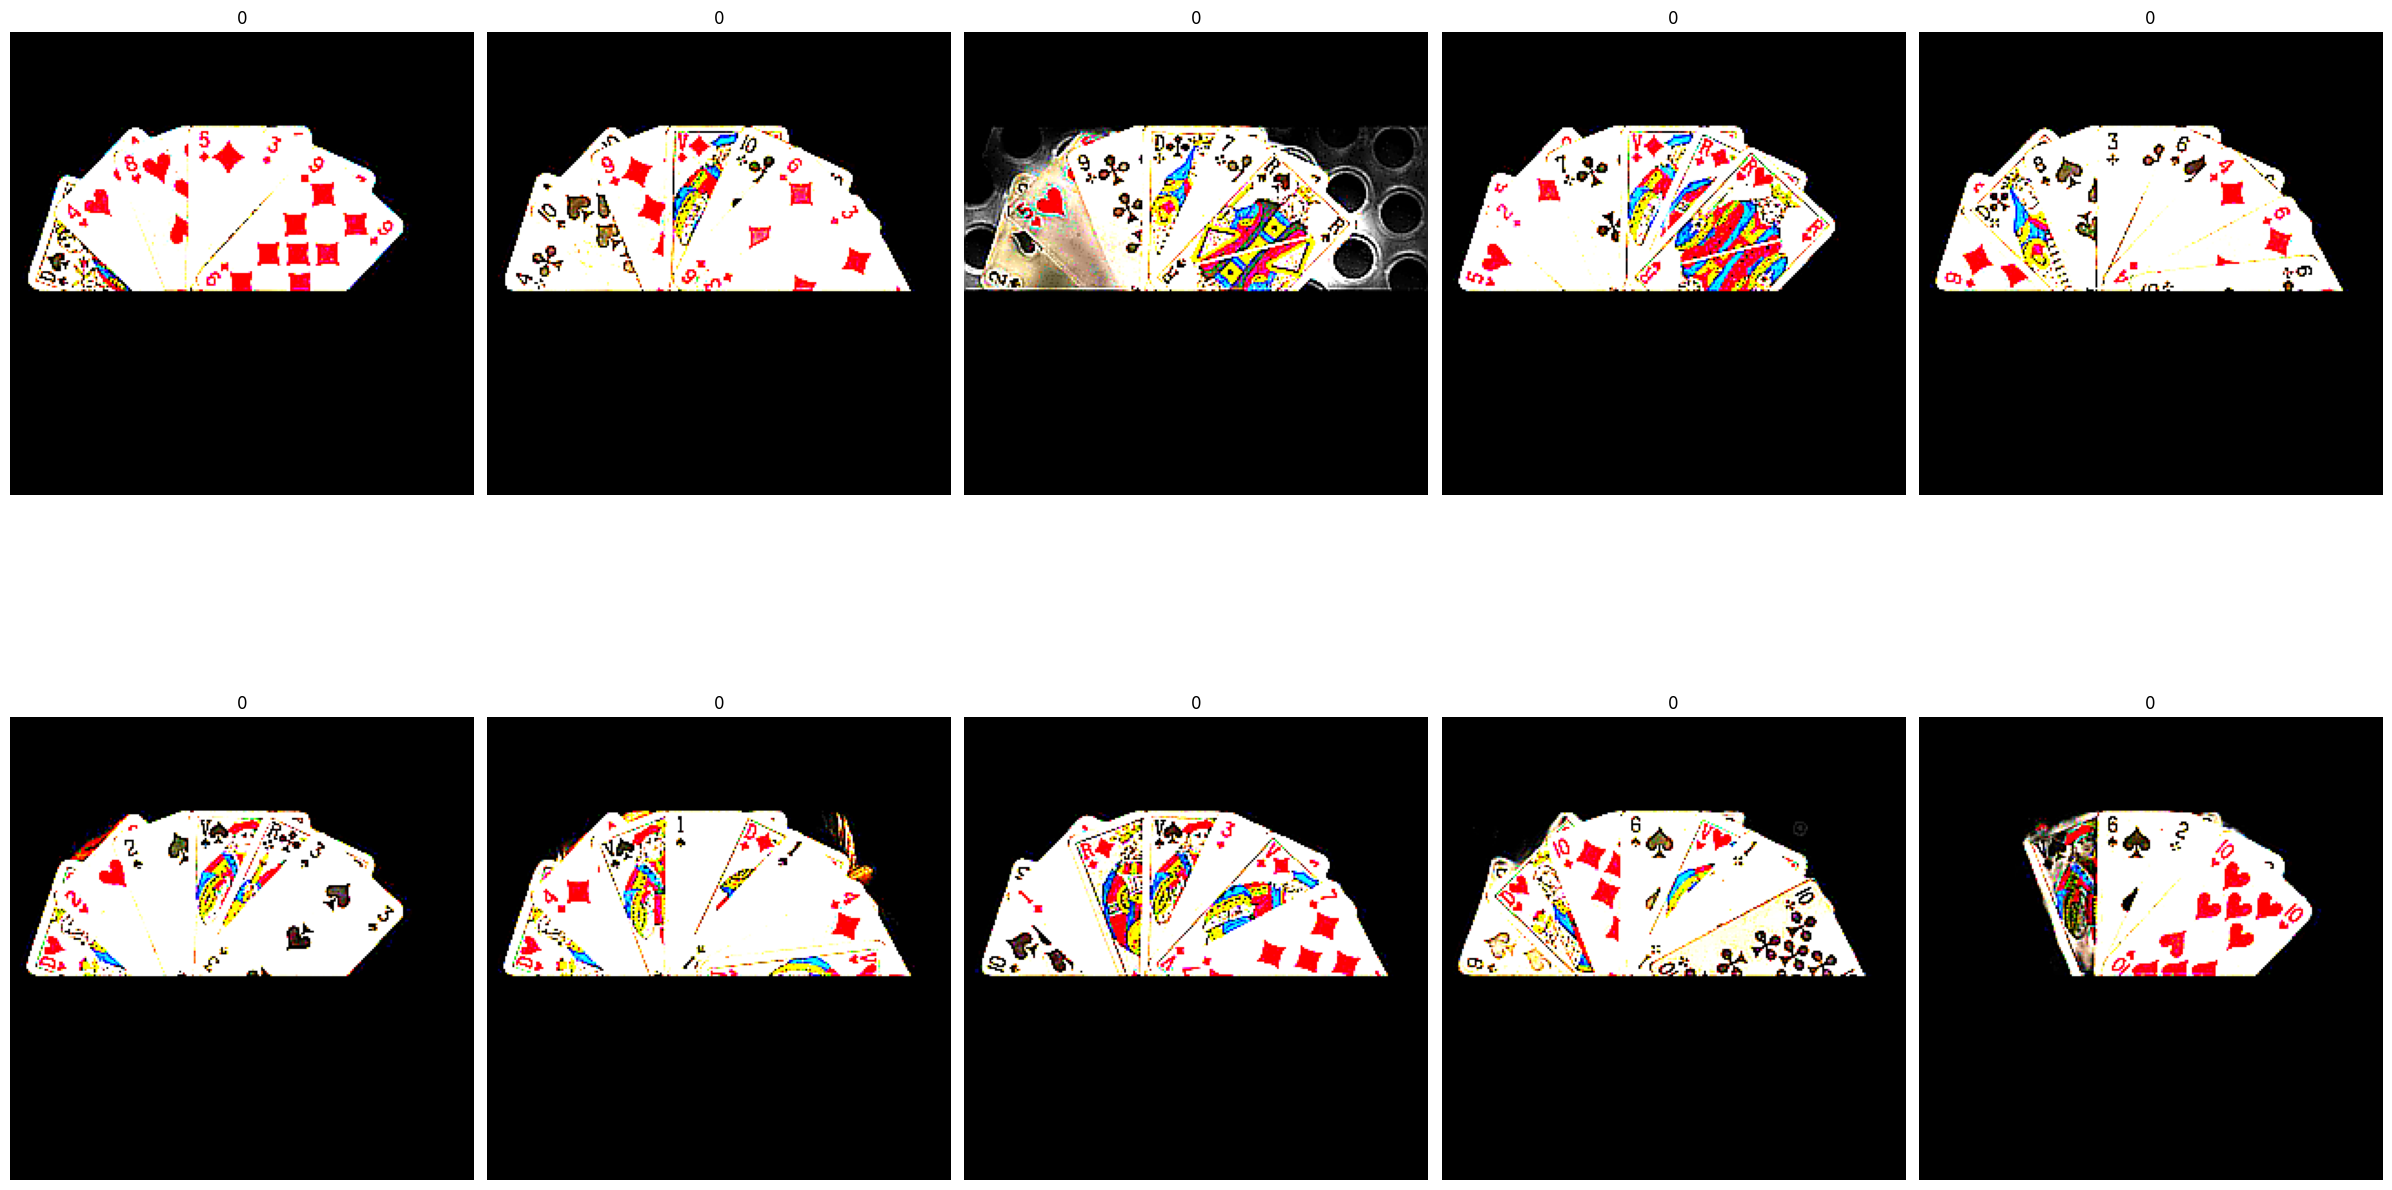

In [14]:
import matplotlib.pyplot as plt
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
%matplotlib inline

#######################################################
           # Visualize Dataset
 #Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    #print(dataset.transform)
    dataset.transform = transforms.Compose([ 
                                transforms.ToPILImage(),
                                transforms.RandomAdjustSharpness(sharpness_factor=0.5),
                                transforms.RandomAutocontrast(),
                                transforms.RandomRotation(degrees=(-20,-20)),
                                transforms.Lambda(crop800),
                                transforms.Pad([0,175,0,375]),
                                transforms.Resize(255),
                                ])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 16))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(test_filenames))
        image, lab = dataset[idx]
        image = transforms.functional.adjust_sharpness(image,sharpness_factor=3)
        image = transforms.functional.adjust_saturation(image,saturation_factor=2)
        image = transforms.functional.adjust_brightness(image,brightness_factor=1.5)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(lab)
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(test_dataset,np.random.randint(1,len(test_filenames)), random_img = True)

## Model, Training, & Testing

### Model VGG16
Ref: https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [15]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def save(self, path):
        torch.save(self.state_dict(), path)

In [16]:
model = VGG16(num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

### Training

In [28]:
# Train the model
total_step = len(train_loader)
res = []
path_a = os.path.join(os.getcwd(), "pretrainmodel_8_25.pth")

def train() :
    total_step = len(train_loader)

    print('> start training...')

    for epoch in range(num_epochs):
        print('...epoch : '+ str(epoch+1) + '...')
        
        for i, (images, labels) in enumerate(train_loader):  
            print('...load image batch '+ str(i) +'...')
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        print('saving model...')
    
        model.save(path_a)
        print('...succeed saving')
                
        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in train_loader:
                print(end='.')
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            print('')
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

### Testing

In [29]:
def test() :
    with torch.no_grad():
        correct = 0
        total = 0
        print("predicting...")
        for images, labels in test_loader:
            print(end='.')
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            for res in predicted :
                dict_res['Total'].append(int(res))
            
            del images, labels, outputs
    
    print('')
    print(dict_res)

    print('Accuracy of the network on the {} test images: {} %'.format(1000, 100 * correct / total))   

## Main

In [33]:
if __name__ == "__main__":
    
    path =  os.path.join(os.getcwd(), "pretrainmodel_8_20.pth")
    

    state_dict = torch.load(path)
    model.load_state_dict(state_dict)

    # Let's build our model
    train()
    print('...Finished Training')

    # temp.sort_values(by=['Filename'])
    # temp.to_csv(os.path.join(os.getcwd(), 'test3.csv'),index=False)

> start training...
...epoch : 1...
...load image batch 0...
...load image batch 1...
...load image batch 2...
...load image batch 3...
...load image batch 4...
...load image batch 5...
...load image batch 6...
...load image batch 7...
...load image batch 8...
...load image batch 9...
...load image batch 10...
...load image batch 11...
...load image batch 12...
...load image batch 13...
...load image batch 14...
...load image batch 15...
...load image batch 16...
...load image batch 17...
...load image batch 18...
...load image batch 19...
...load image batch 20...
...load image batch 21...
...load image batch 22...
...load image batch 23...
...load image batch 24...
...load image batch 25...
...load image batch 26...
...load image batch 27...
...load image batch 28...
...load image batch 29...
...load image batch 30...
...load image batch 31...
...load image batch 32...
...load image batch 33...
...load image batch 34...
...load image batch 35...
...load image batch 36...
...load imag

In [ ]:
state_dict = torch.load(path_a)
model.load_state_dict(state_dict)

dict_res = {'Filename':[], 'Total':[]}
test()

temp = pd.DataFrame(dict_res)

In [ ]:
temp = temp.sort_values(by=['Filename'])
temp.to_csv(os.path.join(os.getcwd(), 'test10.csv'),index=False)